In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Smokum&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Smokum; color:#ff33aa; font-size:35px;'>
    %s</h1>"""%str))

In [2]:
!pip install --upgrade neural_structured_learning --user

     |████████████████████████████████| 120 kB 1.4 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
dhtml('Code Modules & Settings')

In [4]:
import os,numpy as np,pandas as pd
import pylab as pl,seaborn as sn,tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image as kimg
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as tkl
from tensorflow.keras import callbacks as tkc
import neural_structured_learning as nsl
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True

In [5]:
dhtml('Mixed Data')

In [6]:
n1=1100
classes=['plane','car','bird','cat','deer',
         'dog','frog','horse','ship','truck']
(x,y),(_,_)=cifar10.load_data()
x=np.array(x,dtype='float32')/255
y=y.reshape(-1)
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
shuffle_ids=shuffle_ids[:n1]
x,y=x[shuffle_ids],y[shuffle_ids]

170500096/170498071 [==============================] - 2s 0us/step


[(1100, 32, 32, 3), dtype('float32'), (1100,), dtype('uint8')]
Label:  horse


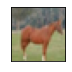

In [7]:
print([x.shape,x.dtype,y.shape,y.dtype])
print('Label: ',classes[y[1]])
pl.figure(figsize=(1,1))
pl.xticks([]); pl.yticks([])
pl.imshow(x[1]);

In [8]:
img_size=32
manners=['pictogram','contour','sketch']
objects=['flower','bird','butterfly','tree',
         'plane','crane','dog','horse',
         'deer','truck','car','cat',
         'frog','ship','fish','house']
fpath='../input/art-pictogram/pictograms/'
flist=sorted(os.listdir(fpath))
def path_to_tensor(img_path,fpath):
    img=kimg.load_img(fpath+img_path,
                      target_size=(img_size,img_size))
    x=kimg.img_to_array(img)
    return np.expand_dims(x,axis=0)
def paths_to_tensor(img_paths,fpath):
    tensor_list=[path_to_tensor(img_path,fpath) 
                 for img_path in tqdm(img_paths)]
    return np.vstack(tensor_list)
labels1=np.array([int(el[:2]) for el in flist],
                 dtype='int8')-1
labels2=np.array([int(el[3:6]) for el in flist],
                 dtype='int8')-1
images=np.array(paths_to_tensor(flist,fpath=fpath))/255
n2=len(labels1[labels1==0])
images=images[:n2]; labels2=labels2[:n2]
cond=np.where([l in classes for l in objects])[0]
cond2=np.where([l in cond for l in labels2])
images=images[cond2]; labels=labels2[cond2]
rd={1:2,4:0,6:5,7:7,8:4,9:9,10:1,11:3,12:6,13:8}
labels=np.array([rd.get(x,x) for x in labels],
                dtype='int8')

100%|██████████| 3143/3143 [00:05<00:00, 550.85it/s]


[(1102, 32, 32, 3), dtype('float32'), (1102,), dtype('int8')]
Label:  bird


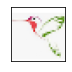

In [9]:
print([images.shape,images.dtype,
       labels.shape,labels.dtype])
print('Label: ',classes[labels[100]])
pl.figure(figsize=(1,1))
pl.xticks([]); pl.yticks([])
pl.imshow(images[100]);

In [10]:
x=np.vstack([x,images])
y=np.hstack([y,labels])
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]
print([x.shape,x.dtype,y.shape,y.dtype])

[(2202, 32, 32, 3), dtype('float32'), (2202,), dtype('int16')]


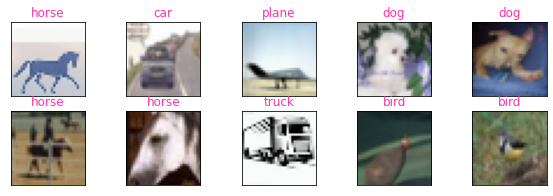

In [11]:
fig=pl.figure(figsize=(10,3))
randch=np.random.choice(x_test.shape[0],
                        size=10,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,5,i+1,
                       xticks=[],yticks=[])
    ax.imshow(x_test[idx])
    true_idx=y_test[idx]
    ax.set_title(classes[true_idx],color="#ff33aa")

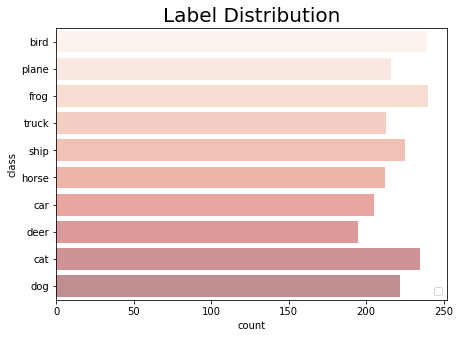

In [12]:
df=pd.DataFrame(y,columns=['label'])
df['class']=[classes[l] for l in y]
pl.figure(figsize=(7,5))
sn.countplot(y='class',data=df,
             palette='Reds',alpha=.5)
ti='Label Distribution'
pl.title(ti,fontsize=20); pl.legend(loc=4);

In [13]:
dhtml('NN Examples')

In [14]:
def cnn_model():
    model=Sequential()
    model.add(tkl.Conv2D(32,(5,5),padding='same',
                         input_shape=x_train.shape[1:]))
    model.add(tkl.Activation('relu'))
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))
    model.add(tkl.Conv2D(96,(5,5)))
    model.add(tkl.Activation('relu'))    
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))
    model.add(tkl.GlobalAveragePooling2D())    
    model.add(tkl.Dense(1024,activation='relu'))
    model.add(tkl.Dropout(.5))         
 #   model.add(tkl.Dense(128,activation='relu'))
 #   model.add(tkl.Dropout(.25)) 
    model.add(tkl.Dense(10))
    model.add(tkl.Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model

In [15]:
cnn_model=cnn_model()
fw='weights.best.hdf5'
early_stopping=tkc.EarlyStopping(monitor='val_loss',
                                 patience=20,verbose=2)
checkpointer=tkc.ModelCheckpoint(filepath=fw,verbose=2,
                                 save_best_only=True)
lr_reduction=tkc.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                                   patience=5,factor=.8)
history=cnn_model.fit(x_train,y_train,epochs=100,
                      batch_size=64,verbose=2,
                      validation_data=(x_valid,y_valid),
                      callbacks=[checkpointer,
                                 early_stopping,
                                 lr_reduction])

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.29731, saving model to weights.best.hdf5
28/28 - 3s - loss: 2.3054 - accuracy: 0.0993 - val_loss: 2.2973 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 2/100

Epoch 00002: val_loss improved from 2.29731 to 2.22411, saving model to weights.best.hdf5
28/28 - 2s - loss: 2.2782 - accuracy: 0.1504 - val_loss: 2.2241 - val_accuracy: 0.1636 - lr: 0.0010
Epoch 3/100

Epoch 00003: val_loss improved from 2.22411 to 2.14415, saving model to weights.best.hdf5
28/28 - 2s - loss: 2.1944 - accuracy: 0.1697 - val_loss: 2.1441 - val_accuracy: 0.1727 - lr: 0.0010
Epoch 4/100

Epoch 00004: val_loss improved from 2.14415 to 2.07830, saving model to weights.best.hdf5
28/28 - 2s - loss: 2.1390 - accuracy: 0.1941 - val_loss: 2.0783 - val_accuracy: 0.2182 - lr: 0.0010
Epoch 5/100

Epoch 00005: val_loss improved from 2.07830 to 2.01732, saving model to weights.best.hdf5
28/28 - 2s - loss: 2.0757 - accuracy: 0.2157 - val_loss: 2.0173 - val_accuracy: 0.2500 - 

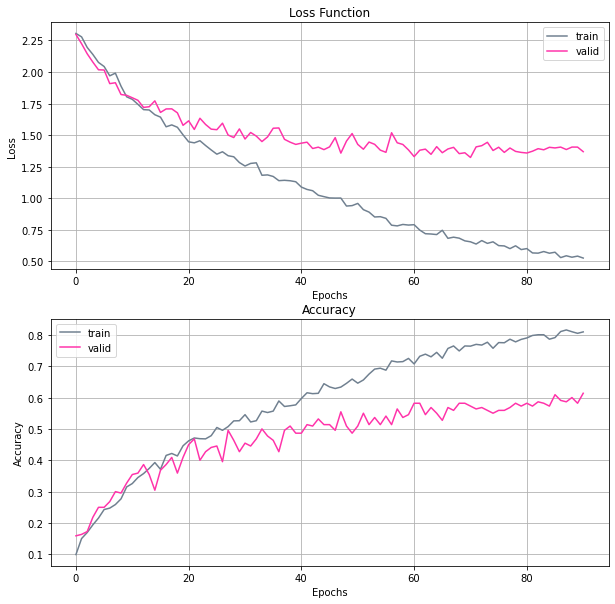

In [16]:
def history_plot(fit_history):
    pl.figure(figsize=(10,10)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='#ff33aa',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='#ff33aa',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()
history_plot(history)

In [17]:
cnn_model.load_weights(fw)
cnn_model.evaluate(x_test,y_test)

7/7 [==============================] - 0s 11ms/step - loss: 1.4504 - accuracy: 0.5227


[1.4503591060638428, 0.5227272510528564]

In [18]:
batch_size=64; img_size=32; n_classes=10; epochs=30
base_model=tf.keras.Sequential([
    tf.keras.Input((img_size,img_size,3),name='input'),
    tf.keras.layers.Conv2D(32,(5,5),padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Conv2D(196,(5,5)),
    tf.keras.layers.Activation('relu'),    
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.GlobalMaxPooling2D(),    
    tf.keras.layers.Dense(512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(n_classes,
                          activation='softmax')
])
adv_config=nsl.configs\
.make_adv_reg_config(multiplier=.2,adv_step_size=.05)
adv_model=nsl.keras\
.AdversarialRegularization(base_model,adv_config=adv_config)
adv_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [19]:
train=tf.data.Dataset.from_tensor_slices(
    {'input':x_train,'label':y_train}).batch(batch_size)
valid=tf.data.Dataset.from_tensor_slices(
    {'input':x_valid,'label':y_valid}).batch(batch_size)
valid_steps=x_valid.shape[0]//batch_size
adv_model.fit(train,validation_data=valid,verbose=2,
              validation_steps=valid_steps,epochs=epochs);

Epoch 1/30
28/28 - 8s - loss: 2.7790 - sparse_categorical_crossentropy: 2.3156 - sparse_categorical_accuracy: 0.1090 - scaled_adversarial_loss: 0.4634 - val_loss: 2.7590 - val_sparse_categorical_crossentropy: 2.2990 - val_sparse_categorical_accuracy: 0.1562 - val_scaled_adversarial_loss: 0.4600
Epoch 2/30
28/28 - 8s - loss: 2.7576 - sparse_categorical_crossentropy: 2.2979 - sparse_categorical_accuracy: 0.1158 - scaled_adversarial_loss: 0.4597 - val_loss: 2.7475 - val_sparse_categorical_crossentropy: 2.2893 - val_sparse_categorical_accuracy: 0.1510 - val_scaled_adversarial_loss: 0.4582
Epoch 3/30
28/28 - 8s - loss: 2.6975 - sparse_categorical_crossentropy: 2.2472 - sparse_categorical_accuracy: 0.1504 - scaled_adversarial_loss: 0.4503 - val_loss: 2.7876 - val_sparse_categorical_crossentropy: 2.3212 - val_sparse_categorical_accuracy: 0.0990 - val_scaled_adversarial_loss: 0.4664
Epoch 4/30
28/28 - 8s - loss: 2.5210 - sparse_categorical_crossentropy: 2.0976 - sparse_categorical_accuracy: 0.

In [20]:
adv_model.evaluate({'input':x_test,'label':y_test})

7/7 [==============================] - 1s 72ms/step - loss: 2.1721 - sparse_categorical_crossentropy: 1.7764 - sparse_categorical_accuracy: 0.4636 - scaled_adversarial_loss: 0.3957


[2.172132730484009, 1.7763901948928833, 0.4636363685131073, 0.3957423269748688]